# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 06) Picture1.jpg

---
**Objetivo deste notebook:** resolver um problema de valor inicial e um problema de valor de contorno envolvendo uma EDO de 2a ordem. Veremos as nuâncias de como tratar cada um dos casos.

---
### EXEMPLO 5

**Objetivo:** Neste exemplo vamos resolver o problema de valor inicial dado pela equação não-homogênea $$y''(t)+5 y'(t) + 6 y(t)=e^{-t}$$ com condições iniciais $y(0)=-1$ e $y'(0)=2$.

* Esse PVI tem solução analítica dada por $y(t)=\frac{1}{2} e^{-3t} \left(1-4e^{t}+e^{2t}\right)$.

---
Começamos instalando a biblioteca DeepXDE

In [ ]:
!pip install deepxde -q gwpy

---
Em seguida importamos o necessário

In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

---
**1$^\mathrm{a}$ Etapa**

Começamos definindo a equação diferencial a se trabalhar.

Começamos definindo a função `ode` com duas entradas: (1) a variável independente `t` e (2) a variável dependente `y`.

Para escrevemos a equação diferencial precisamos da derivada da variável dependente. No DeepXDE a 1$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.jacobian(y, t)` e a 2$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.hessian(y, t)`.

Por fim retornamos a equação na forma $y''+5 y'+ 6 y=e^{-t},$ uma vez que o objetivo da rede é minimizar este termo de forma que ele esteja próximo de zero.

*Obs.:* como estamos usando o `tensorflow` como *backend* precisamos chamar a exponencial definida pelo `tensorflow`. Caso seja usada a versão do `numpy` o código retornará alguma erro e não irá rodar.

In [ ]:
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 + 5 * dy_dt + 6 * y - tf.math.exp(-t) # exponencial definida no tensorflow

---
**2$^\mathrm{a}$ Etapa**

Vamos agora definir a geometria do nosso domínio e as condições iniciais.

Novamente, como estamos lidando com uma EDO, nossa geometria será um intervalo na reta $\mathbb{R}$. Fazemos essa definição utilizando o comando `dde.geometry.TimeDomain(a, b)`.

Em seguida, como estamos lidando com duas condições iniciais à esquerda (o usual) vamos definir uma função `boundary_l` que retorna o ponto na fronteira $t=a$.

Finalmente utilizando o módulo de condições iniciais e de fronteira do DeepXDE chamamos a função `dde.icbc.IC(...)` cujas entradas são: (1) a geometria; (2) o valor da condição inicial e (3) qual ponto está a condição inicial.

Aqui temos um detalhe importante, pois o módulo `dde.icbc.IC(...)` é capaz de definir apenas uma condição inicial que é $y(a)=y_0$. Portanto, precisamos definir a 2$^\mathrm{a}$ condição inicial $y'(a)=y_1$ utilizando o módulo `dde.icbc.OperatorBC` que permite definir condições de contorno gerais. Neste caso, através da função `bc_func` calculamos a derivada da rede e fazemos a diferença dela com a condição inicial `y_1`, isto se deve pois o módulo `OperatorBC` deve retornar como entrada uma função nula: `func(inputs, outputs, X) = 0`.

*Obs.: Alternativamente seria possível utilizar o módulo `dde.icbc.NeumannBC(...)`, faça o teste depois* ;-)

In [ ]:
a = 0
b = 2
y_0 = -1
y_1 = 2

geom = dde.geometry.TimeDomain(a, b)

def boundary_l(t, on_initial):
    return on_initial and dde.utils.isclose(t[0], a)

def bc_func(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - y_1

# essa linha poderia ser reescrita como ic1 = dde.icbc.IC(geom, lambda x: y_0, boundary_l)
ic1 = dde.icbc.IC(geom, lambda x: y_0, lambda _, on_initial: on_initial) # define y(t_0)=y_0

ic2 = dde.icbc.OperatorBC(geom, bc_func, boundary_l) # define y'(t_0)=y_1

---
**3$^\mathrm{a}$ Etapa**

Montamos agora a estrutura da nossa rede neural.

Primeiro passo é utilizar o método `TimePDE` para incluir as informações que definimos no passo anterior: (1) geometria; (2) equação diferencial; (3) condições iniciais e (4) a quantidade de pontos amostrados aleatoriamente no interior do domínio e na fronteira.

Em seguida devemos escolher os parâmetros da rede como: (1) número de camadas e neurônios, (2) função de ativação e (3) o inicializador dos pesos.

Por último compilamos o modelo para fazer a mágica acontecer.

In [ ]:
data = dde.data.TimePDE(geom, ode, [ic1, ic2], num_domain=64, num_boundary=1)
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
Building feed-forward neural network...
'build' took 0.071328 s

'compile' took 0.770398 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [7.41e-01, 1.00e+00, 3.93e+00]    [7.41e-01, 1.00e+00, 3.93e+00]    []  
1000      [6.91e-05, 2.37e-07, 3.49e-07]    [6.91e-05, 2.37e-07, 3.49e-07]    []  
2000      [4.59e-05, 7.49e-09, 3.19e-08]    [4.59e-05, 7.49e-09, 3.19e-08]    []  
3000      [4.27e-05, 4.10e-09, 2.53e-08]    [4.27e-05, 4.10e-09, 2.53e-08]    []  
4000      [3.75e-05, 8.19e-10, 1.35e-08]    [3.75e-05, 8.19e-10, 1.35e-08]    []  
5000      [3.38e-05, 2.83e-10, 9.21e-09]    [3.38e-05, 2.83e-10, 9.21e-09]    []  
6000      [3.19e-05, 2.90e-09, 7.61e-09]    [3.19e-05, 2.90e-09, 7.61e-09]    []  
7000      [2.14e-05, 3.41e-12, 3.55e-09]    [2.14e-05, 3.41e-12, 3.55e-09]    []  
8000      [4.88e-03, 9.93e-06, 1.03e-04]    [4.88e-03, 9.93e-06, 1.03e-04]    []  
9000      [3.99e-05, 1.05e-07, 6.

---
**4$^\mathrm{a}$ Etapa**

Finalmente, após fazer os cálculos necessários, vamos verificar se a rede produziu a solução esperada comparando com a solução conhecida.

Aqui vamos utilizar a função `geom.uniform_points` para gerar a malha necessária para os gráficos e `model.predict` para gerar as imagens dos pontos da malha.

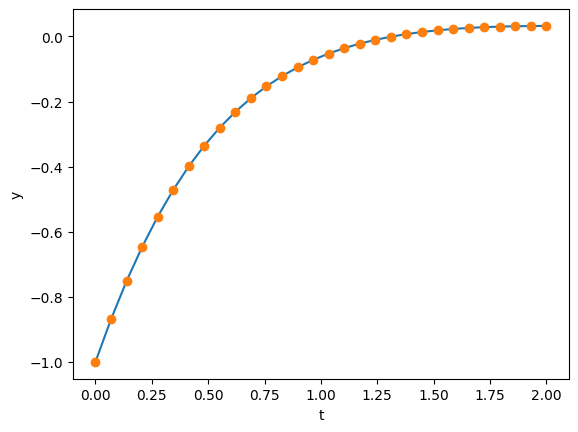

In [ ]:
def func(t):
    return 0.5 * np.exp(-3*t)*(1 - 4 * np.exp(t) + np.exp(2*t))

x = geom.uniform_points(30, True)
y = model.predict(x)
y_test = func(x)
plt.figure()
plt.plot(x, y,x,y_test,'o')
plt.xlabel("t")
plt.ylabel("y")
plt.show()

---
### EXEMPLO 6

**Objetivo:** Neste exemplo vamos resolver o problema de valor inicial dado pela equação não-homogênea $$y''(t)+9 y(t)=\cos{t}$$ com condições de fronteira $y'(\pi/4)=5$ e $y'(\pi/2)=-5/3$.

* Esse PVC tem solução dada por $y(t)=\frac{1}{72} \left(9 \cos(x) - 37 \cos(3 x) + 2 (17 - 60 \sqrt{2}) \sin(3 x)\right)$.

---
**1$^\mathrm{a}$ Etapa**

Novamente começamos definindo a equação diferencial a se trabalhar.

Começamos definindo a função `ode` com duas entradas: (1) a variável independente `t` e (2) a variável dependente `y`.

Para escrevemos a equação diferencial precisamos da derivada da variável dependente. No DeepXDE a 1$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.jacobian(y, t)` e a 2$^\mathrm{a}$ derivada é calculada utilizando o comando `dde.grad.hessian(y, t)`.

Por fim retornamos a equação na forma $y''+9 y-\cos(t),$ uma vez que o objetivo da rede é minimizar este termo de forma que ele esteja próximo de zero.

In [ ]:
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 + 9 * y - tf.math.cos(t) # lembre-se de usar o cosseno do tensorflow ;)

---
**2$^\mathrm{a}$ Etapa**

Vamos agora definir a geometria do nosso domínio e as condições iniciais.

Novamente, como estamos lidando com uma EDO, nossa geometria será um intervalo na reta $\mathbb{R}$. Fazemos essa definição utilizando o comando `dde.geometry.TimeDomain(a, b)`.

Em seguida, como estamos lidando com duas condições de contorno vamos definir duas funções `boundary_l` e `boundary_r` que retornam os pontos nas fronteiras $t=a$ e $t=b$.

Finalmente iremos utilizar o módulo de condições de contorno de Neumann `dde.icbc.NeumannBC(...)` cujas entradas são: (1) a geometria; (2) o valor da condição inicial e (3) qual ponto está a condição de fronteira.

*Obs.: Note que na condição à esquerda a o valor dado está com o sinal trocado, isto deve sempre acontecer porque o vetor normal deste lado está virado para a esquerda*

In [ ]:
a = np.pi/4
b = np.pi/2
y_0 = 5
y_1 = -5/3

geom = dde.geometry.TimeDomain(a, b)

def boundary_l(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], a)

def boundary_r(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], b)

ic1 = dde.icbc.NeumannBC(geom, lambda x: -y_0, boundary_l)
ic2 = dde.icbc.NeumannBC(geom, lambda x: y_1, boundary_r)

---
**3$^\mathrm{a}$ Etapa**

Montamos agora a estrutura da nossa rede neural.

Primeiro passo é utilizar o método `TimePDE` para incluir as informações que definimos no passo anterior: (1) geometria; (2) equação diferencial; (3) condições iniciais e (4) a quantidade de pontos amostrados aleatoriamente no interior do domínio e na fronteira.

Em seguida devemos escolher os parâmetros da rede como: (1) número de camadas e neurônios, (2) função de ativação e (3) o inicializador dos pesos.

Por último compilamos o modelo para fazer a mágica acontecer.

In [ ]:
data = dde.data.TimePDE(geom, ode, [ic1, ic2], num_domain=64, num_boundary=2)
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=False, isplot=False)

Compiling model...
Building feed-forward neural network...
'build' took 0.076731 s

'compile' took 0.867757 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.64e-01, 2.43e+01, 3.24e+00]    [2.64e-01, 2.43e+01, 3.24e+00]    []  
1000      [8.65e-04, 3.49e-08, 1.94e-06]    [8.65e-04, 3.49e-08, 1.94e-06]    []  
2000      [3.30e-04, 6.59e-07, 9.78e-08]    [3.30e-04, 6.59e-07, 9.78e-08]    []  
3000      [2.74e-04, 5.71e-07, 6.96e-08]    [2.74e-04, 5.71e-07, 6.96e-08]    []  
4000      [2.34e-04, 1.19e-06, 7.11e-07]    [2.34e-04, 1.19e-06, 7.11e-07]    []  
5000      [1.94e-04, 1.06e-06, 7.60e-07]    [1.94e-04, 1.06e-06, 7.60e-07]    []  
6000      [1.27e-04, 2.92e-07, 7.78e-09]    [1.27e-04, 2.92e-07, 7.78e-09]    []  
7000      [1.30e-04, 1.74e-07, 3.84e-11]    [1.30e-04, 1.74e-07, 3.84e-11]    []  
8000      [1.58e-04, 1.98e-07, 1.23e-10]    [1.58e-04, 1.98e-07, 1.23e-10]    []  
9000      [1.93e-04, 6.94e-07, 1.

---
**4$^\mathrm{a}$ Etapa**

Finalmente, após fazer os cálculos necessários, vamos verificar se a rede produziu a solução esperada comparando com a solução conhecida.

Aqui vamos utilizar a função `geom.uniform_points` para gerar a malha necessária para os gráficos e `model.predict` para gerar as imagens dos pontos da malha.

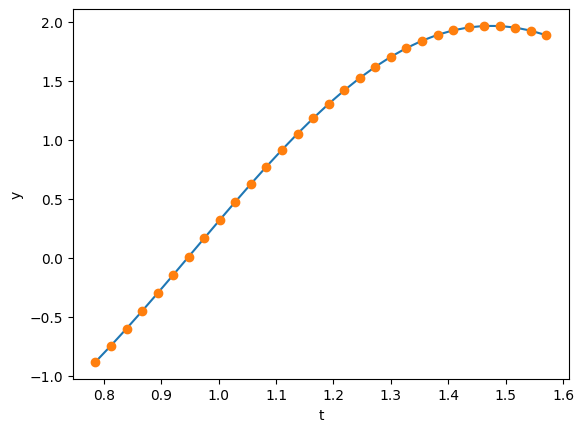

In [ ]:
def func(t):
    return (1/72) * (9*np.cos(x) - 37*np.cos(3*x) + 2*(17 - 60*np.sqrt(2))*np.sin(3*x))

x = geom.uniform_points(30, True)
y = model.predict(x)
y_test = func(x)
plt.figure()
plt.plot(x, y,x,y_test,'o')
plt.xlabel("t")
plt.ylabel("y")
plt.show()